# Machine Learning Principles Final Assignment!


## data exploration

In [4]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_valid = pd.read_csv('valid.csv')

df_whole = pd.concat([df_train, df_valid, df_test], axis=0)

## letter and punctuation frequency

TRAINING INFORMATION


                                                text  label
0  states slow to shut down weak teacher educatio...      0
1    drone places fresh kill on steps of white house      1
2  report: majority of instances of people gettin...      1
3  sole remaining lung filled with rich, satisfyi...      1
4                       the gop's stockholm syndrome      0
distribution of labels
label
0    11248
1    10216
Name: count, dtype: int64


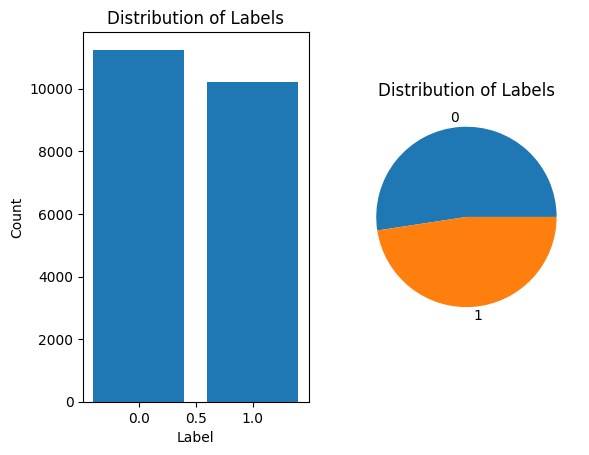

    label punct  count
1       0     .    700
17      1     .    376
num_ellipsis_0: 153
num_ellipsis_1: 6
    label punct  count
1       0     .    547
17      1     .    370


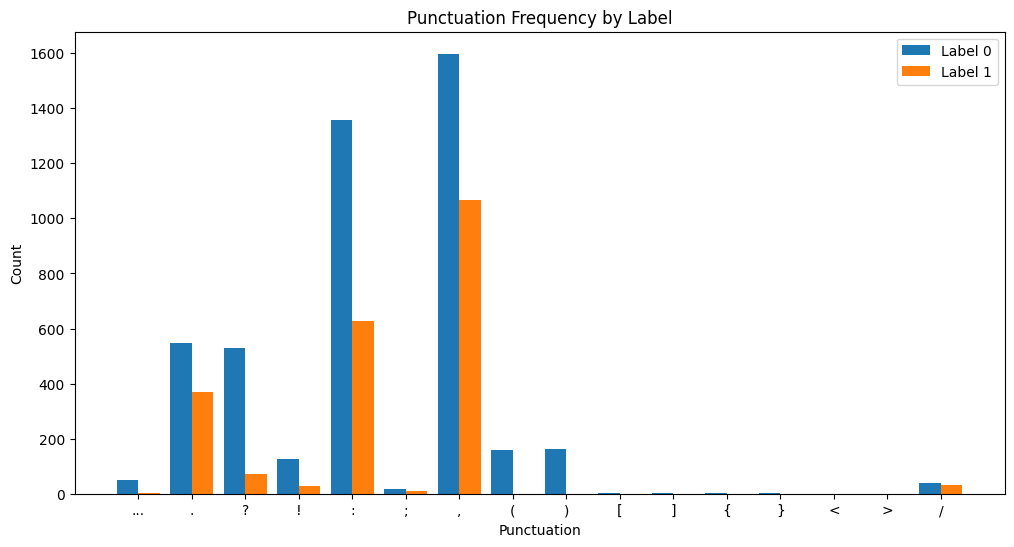

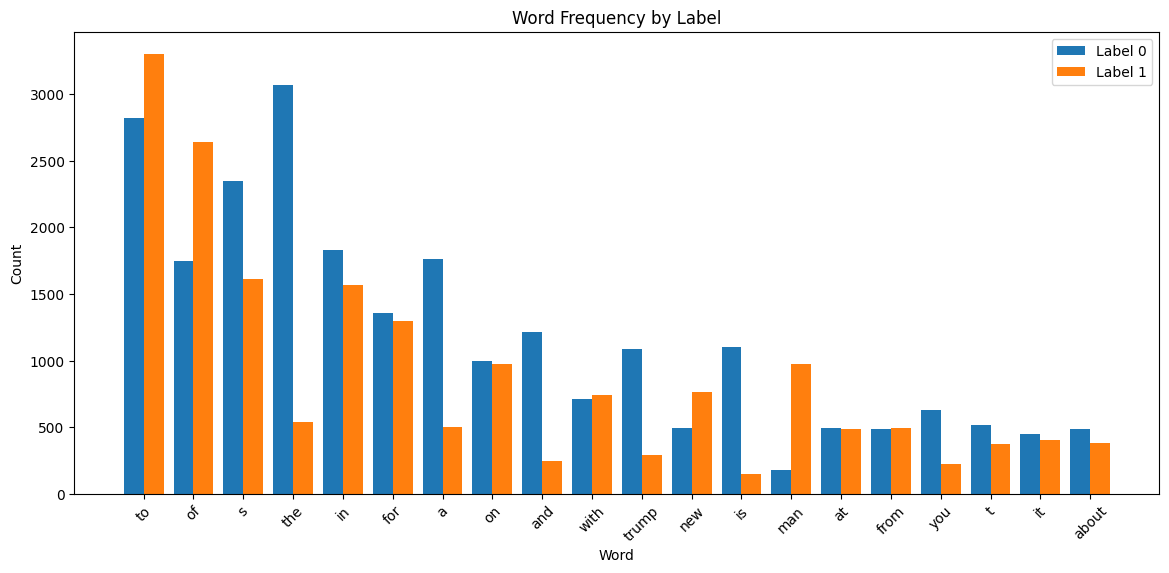

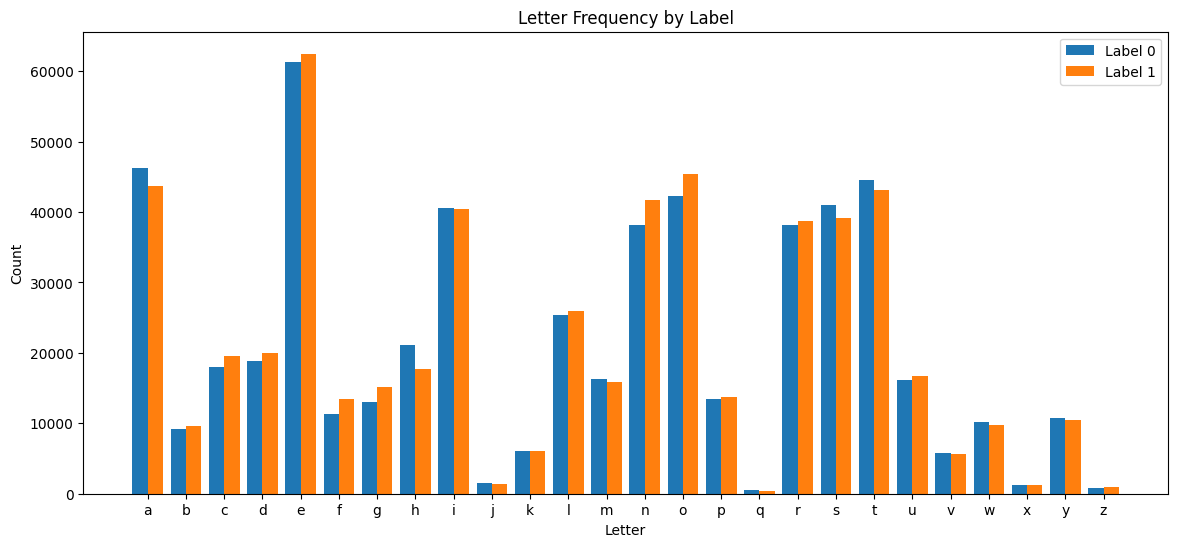

In [6]:
print("TRAINING INFORMATION")
print()
print()
print(df_train.head())
print("distribution of labels")

label_counts = df_train['label'].value_counts()
print(label_counts)
fig, ax = plt.subplots(1, 2)

ax[0].bar(label_counts.index, label_counts.values)
ax[0].set_title('Distribution of Labels')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Count')

ax[1].pie(label_counts.values, labels=label_counts.index)
ax[1].set_title('Distribution of Labels')

plt.show()


# for each label, show counts of punctuation
import re

punctuation = ['...', '.', '?', '!', ':', ';', ',', '(', ')', '[', ']', '{', '}', '<', '>', '/']

rows = []

for label in df_train['label'].unique():
    texts = df_train[df_train['label'] == label]['text']
    counted = False
    for punct in punctuation:
        count = texts.str.contains(re.escape(punct)).sum()
        rows.append({
            'label': label,
            'punct': punct,
            'count': count
        })

punct_df = pd.DataFrame(rows)

#reomve elipses count from period count
print(punct_df[punct_df['punct'] == '.'])

# Count ellipses for each label
num_ellipsis_0 = punct_df[(punct_df['punct'] == '...') & (punct_df['label'] == 0)]['count'].iloc[0] * 3
num_ellipsis_1 = punct_df[(punct_df['punct'] == '...') & (punct_df['label'] == 1)]['count'].iloc[0] * 3

print(f'num_ellipsis_0: {num_ellipsis_0}')
print(f'num_ellipsis_1: {num_ellipsis_1}')

# Subtract ellipses from period counts using .loc and index
idx0 = punct_df[(punct_df['punct'] == '.') & (punct_df['label'] == 0)].index[0]
idx1 = punct_df[(punct_df['punct'] == '.') & (punct_df['label'] == 1)].index[0]

punct_df.loc[idx0, 'count'] -= num_ellipsis_0
punct_df.loc[idx1, 'count'] -= num_ellipsis_1

print(punct_df[punct_df['punct'] == '.'])



labels = punct_df['label'].unique()
puncts = punctuation

x = np.arange(len(puncts))     
width = 0.8 / len(labels)      

fig, ax = plt.subplots(figsize=(12, 6))

for i, label in enumerate(labels):
    counts = punct_df[punct_df['label'] == label]['count']
    ax.bar(x + i*width, counts, width, label=f"Label {label}")

ax.set_xticks(x + width * (len(labels) - 1) / 2)
ax.set_xticklabels(puncts)
ax.set_xlabel("Punctuation")
ax.set_ylabel("Count")
ax.set_title("Punctuation Frequency by Label")
ax.legend()

plt.show()


from collections import Counter

# tokenize all text
all_words = []
for text in df_train['text']:
    all_words.extend(re.findall(r'\b\w+\b', text.lower()))

# pick top 20
most_common = [w for w, c in Counter(all_words).most_common(20)]
words = most_common

word_rows = []

for label in df_train['label'].unique():
    texts = df_train[df_train['label'] == label]['text']

    for w in words:
        # case-insensitive count of whole word
        count = texts.str.contains(rf'\b{re.escape(w)}\b', case=False).sum()
        
        word_rows.append({
            "label": label,
            "item": w,
            "count": count
        })

word_df = pd.DataFrame(word_rows)
import matplotlib.pyplot as plt
import numpy as np

labels = word_df['label'].unique()
items = words

x = np.arange(len(items))
width = 0.8 / len(labels)

fig, ax = plt.subplots(figsize=(14, 6))

for i, label in enumerate(labels):
    counts = word_df[word_df['label'] == label]['count']
    ax.bar(x + i*width, counts, width, label=f"Label {label}")

ax.set_xticks(x + width*(len(labels)-1)/2)
ax.set_xticklabels(items, rotation=45)
ax.set_xlabel("Word")
ax.set_ylabel("Count")
ax.set_title("Word Frequency by Label")
ax.legend()

plt.show()


import string
letters = list(string.ascii_lowercase)
import re

letter_rows = []

for label in df_train['label'].unique():
    texts = df_train[df_train['label'] == label]['text']

    for letter in letters:
        # count occurrences across all texts
        count = texts.str.count(letter).sum()
        
        letter_rows.append({
            "label": label,
            "item": letter,
            "count": count
        })

letter_df = pd.DataFrame(letter_rows)
labels = letter_df['label'].unique()
items = letters

x = np.arange(len(items))
width = 0.8 / len(labels)

fig, ax = plt.subplots(figsize=(14, 6))

for i, label in enumerate(labels):
    counts = letter_df[letter_df['label'] == label]['count']
    ax.bar(x + i*width, counts, width, label=f"Label {label}")

ax.set_xticks(x + width*(len(labels)-1)/2)
ax.set_xticklabels(items)
ax.set_xlabel("Letter")
ax.set_ylabel("Count")
ax.set_title("Letter Frequency by Label")
ax.legend()

plt.show()



## capital letters

In [7]:
import pandas as pd


# Function to count capital letters in a string
def count_capitals(text):
    return sum(1 for c in str(text) if c.isupper())

# Apply to your dataframe
df_train['capital_count'] = df_train['text'].apply(count_capitals)

# Descriptive statistics of capital letters per label
capital_stats = df_train.groupby('label')['capital_count'].describe()
print(capital_stats)

avg_capitals = df_train.groupby('label')['capital_count'].mean()
print("\nAverage capital letters per label:\n", avg_capitals)


         count  mean  std  min  25%  50%  75%  max
label                                             
0      11248.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1      10216.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Average capital letters per label:
 label
0    0.0
1    0.0
Name: capital_count, dtype: float64


## descriptive statistics with word frequencies

Word count stats per label:
         count       mean       std  min  25%   50%   75%    max
label                                                           
0      11248.0   9.804587  2.880052  2.0  8.0  10.0  12.0   38.0
1      10216.0  10.287686  3.889435  2.0  8.0  10.0  13.0  151.0

Average sentence length per label:
label
0     9.804587
1    10.287686
Name: word_count, dtype: float64


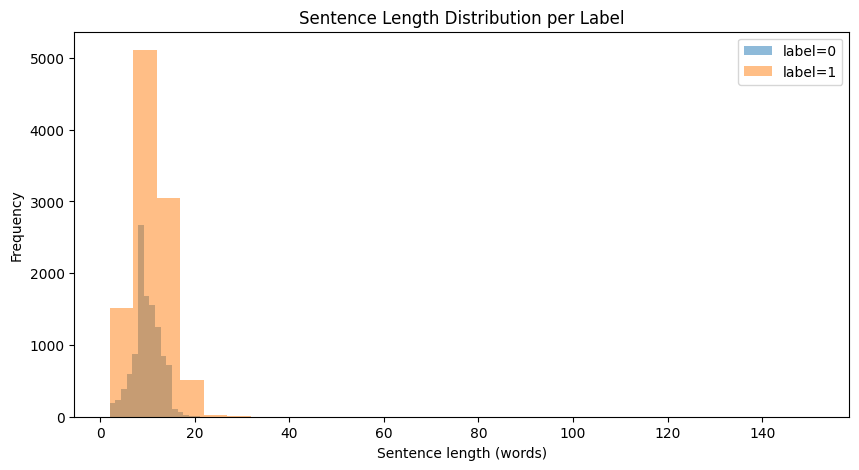


Frequency of n-grams (2-10):

Top 2-grams:
('in', 'the'): 265
('donald', 'trump'): 259
('of', 'the'): 253
('to', 'be'): 245
('out', 'of'): 203
('area', 'man'): 176
('how', 'to'): 175
('to', 'get'): 157
('white', 'house'): 147
('to', 'the'): 142

Top 3-grams:
('you', 'need', 'to'): 51
('need', 'to', 'know'): 39
('new', 'study', 'finds'): 28
('state', 'of', 'the'): 26
("'game", 'of', "thrones'"): 25
('to', 'be', 'a'): 24
('in', 'front', 'of'): 24
('of', 'the', 'union'): 24
('this', 'is', 'what'): 23
('will', 'make', 'you'): 20

Top 4-grams:
('you', 'need', 'to', 'know'): 37
('state', 'of', 'the', 'union'): 24
('what', 'you', 'need', 'to'): 19
('huffpost', 'rise:', 'what', 'you'): 16
('rise:', 'what', 'you', 'need'): 16
('need', 'to', 'know', 'on'): 16
('what', "it's", 'like', 'to'): 15
('need', 'to', 'know', 'about'): 14
('funniest', 'tweets', 'from', 'women'): 12
('tweets', 'from', 'women', 'this'): 12

Top 5-grams:
('what', 'you', 'need', 'to', 'know'): 19
('huffpost', 'rise:', 'what'

In [10]:
import pandas as pd
from collections import Counter
from nltk import ngrams
from textblob import TextBlob
import matplotlib.pyplot as plt

# -----------------------------
# 1. Word count per label
# -----------------------------
def word_count_per_label(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    return df.groupby('label')['word_count'].describe()

# -----------------------------
# 2. Avg sentence length per label
# -----------------------------
def avg_sentence_length_per_label(df):
    # sentence length in words
    return df.groupby('label')['word_count'].mean()

# -----------------------------
# 3. Distribution of sentence length
# -----------------------------
def plot_sentence_length_distribution(df):
    plt.figure(figsize=(10,5))
    for label in df['label'].unique():
        subset = df[df['label']==label]
        plt.hist(subset['word_count'], bins=30, alpha=0.5, label=f'label={label}')
    plt.xlabel('Sentence length (words)')
    plt.ylabel('Frequency')
    plt.title('Sentence Length Distribution per Label')
    plt.legend()
    plt.show()

# -----------------------------
# 4. Frequency of n-grams (2-10)
# -----------------------------
def ngram_frequency(df, n_range=(2,10)):
    all_text = df['text'].apply(lambda x: str(x).split())
    for n in range(n_range[0], n_range[1]+1):
        print(f"\nTop {n}-grams:")
        ngram_counter = Counter()
        for words in all_text:
            ngram_counter.update(list(ngrams(words, n)))
        for gram, freq in ngram_counter.most_common(10):
            print(f"{gram}: {freq}")

# -----------------------------
# 5. Sentiment frequency per label
# -----------------------------
def sentiment_per_label(df):
    df['polarity'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['sentiment'] = df['polarity'].apply(lambda x: 'positive' if x>0 else ('negative' if x<0 else 'neutral'))
    return df.groupby(['label','sentiment']).size().unstack(fill_value=0)

# -----------------------------
# 6. First / last word frequency per label
# -----------------------------
def first_last_word_freq(df):
    df['first_word'] = df['text'].apply(lambda x: str(x).split()[0] if len(str(x).split())>0 else '')
    df['last_word'] = df['text'].apply(lambda x: str(x).split()[-1] if len(str(x).split())>0 else '')
    first_freq = df.groupby('label')['first_word'].apply(lambda x: Counter(x)).to_dict()
    last_freq = df.groupby('label')['last_word'].apply(lambda x: Counter(x)).to_dict()
    return first_freq, last_freq

# -----------------------------
# RUN EVERYTHING
# -----------------------------
# 1 & 2
print("Word count stats per label:")
print(word_count_per_label(df_train))
print("\nAverage sentence length per label:")
print(avg_sentence_length_per_label(df_train))

# 3
plot_sentence_length_distribution(df_train)

# 4
print("\nFrequency of n-grams (2-10):")
ngram_frequency(df_train, n_range=(2,10))

# 5
print("\nSentiment frequency per label:")
print(sentiment_per_label(df_train))

# 6
first_freq, last_freq = first_last_word_freq(df_train)
print("\nFirst word frequency per label:")
print(first_freq)
print("\nLast word frequency per label:")
print(last_freq)


Word count stats per label:

=== WORD COUNT STATS PER LABEL ===
         count       mean       std  min  25%   50%   75%    max
label                                                           
0      11248.0   9.804587  2.880052  2.0  8.0  10.0  12.0   38.0
1      10216.0  10.287686  3.889435  2.0  8.0  10.0  13.0  151.0

Label distribution (counts and %):
       count  percentage
label                   
0      11248        52.4
1      10216        47.6

Average sentence length per label:

=== AVERAGE SENTENCE LENGTH PER LABEL ===
label
0     9.804587
1    10.287686
Name: word_count, dtype: float64

Label distribution (%):
label
0    52.4
1    47.6
dtype: float64

=== SENTENCE LENGTH DISTRIBUTION PER LABEL (PERCENTAGES) ===

Label 0:
        bin  count  percentage
0       0-5    421        3.74
1      5-10   4537       40.34
2     10-15   5815       51.70
3     15-20    452        4.02
4     20-25     19        0.17
5     25-30      3        0.03
6     30-35      0        0.00
7     

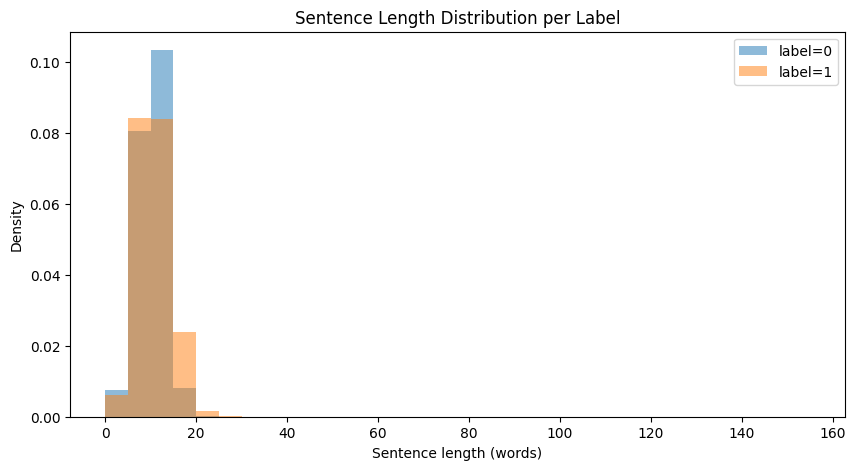


Frequency of n-grams (2-10):

=== N-GRAM FREQUENCIES PER LABEL ===

----- Top 2-grams per label -----

Label 0:
('donald', 'trump'): 249 (0.25%)
('in', 'the'): 232 (0.23%)
('of', 'the'): 192 (0.19%)
('how', 'to'): 146 (0.15%)
('to', 'the'): 128 (0.13%)
('to', 'be'): 115 (0.12%)
('on', 'the'): 112 (0.11%)
('and', 'the'): 106 (0.11%)
('is', 'a'): 105 (0.11%)
('for', 'the'): 97 (0.1%)

Label 1:
('area', 'man'): 176 (0.19%)
('out', 'of'): 150 (0.16%)
('to', 'be'): 130 (0.14%)
('to', 'get'): 102 (0.11%)
('white', 'house'): 96 (0.1%)
('study', 'finds'): 94 (0.1%)
('going', 'to'): 81 (0.09%)
('of', 'the'): 61 (0.06%)
('forced', 'to'): 60 (0.06%)
('trying', 'to'): 58 (0.06%)

----- Top 3-grams per label -----

Label 0:
('you', 'need', 'to'): 50 (0.06%)
('need', 'to', 'know'): 39 (0.04%)
('this', 'is', 'what'): 22 (0.03%)
('to', 'be', 'a'): 21 (0.02%)
('will', 'make', 'you'): 20 (0.02%)
('what', 'you', 'need'): 19 (0.02%)
('to', 'know', 'about'): 17 (0.02%)
('huffpost', 'rise:', 'what'): 16 (0

({0: Counter({'the': 720,
           'how': 295,
           'this': 248,
           'why': 213,
           'a': 181,
           'trump': 150,
           'what': 142,
           'donald': 131,
           "here's": 97,
           '5': 91,
           'watch': 78,
           'new': 72,
           'these': 66,
           '10': 65,
           'is': 56,
           "trump's": 55,
           '7': 50,
           'hillary': 50,
           'man': 50,
           'obama': 47,
           'u.s.': 46,
           '6': 44,
           'an': 41,
           '3': 40,
           'i': 39,
           'in': 38,
           'john': 38,
           'when': 38,
           'gop': 38,
           'huffpost': 37,
           'my': 37,
           'watch:': 36,
           'bernie': 34,
           '4': 34,
           'you': 34,
           "it's": 32,
           'bill': 30,
           'women': 29,
           '8': 29,
           'on': 28,
           'will': 28,
           'woman': 28,
           'republicans': 27,
           '

In [ ]:
import pandas as pd
from collections import Counter
from nltk import ngrams
from textblob import TextBlob
import matplotlib.pyplot as plt

# =====================================================================
# Utility: Convert counts to percentages per label
# =====================================================================
def percentages(series):
    total = series.sum()
    return (series / total * 100).round(2)

# =====================================================================
# 1. Word count per label
# =====================================================================
def word_count_per_label(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    stats = df.groupby('label')['word_count'].describe()

    print("\n=== WORD COUNT STATS PER LABEL ===")
    print(stats)

    # Add counts and percentages
    counts = df.groupby('label').size()
    pct = percentages(counts)

    print("\nLabel distribution (counts and %):")
    print(pd.DataFrame({'count': counts, 'percentage': pct}))

    return stats


# =====================================================================
# 2. Avg sentence length per label
# =====================================================================
def avg_sentence_length_per_label(df):

    avg_len = df.groupby('label')['word_count'].mean()

    print("\n=== AVERAGE SENTENCE LENGTH PER LABEL ===")
    print(avg_len)

    pct = percentages(df.groupby('label').size())

    print("\nLabel distribution (%):")
    print(pct)

    return avg_len


# =====================================================================
# 3. Distribution of sentence length per label (clean + comparable)
# =====================================================================
def plot_sentence_length_distribution(df):

    print("\n=== SENTENCE LENGTH DISTRIBUTION PER LABEL (PERCENTAGES) ===")

    # Print counts + percentages per bin per label
    max_len = df['word_count'].max()
    bins = range(0, max_len + 5, 5)

    for label in df['label'].unique():
        subset = df[df['label'] == label]['word_count']
        hist, bin_edges = np.histogram(subset, bins=bins)
        pct = percentages(pd.Series(hist))

        print(f"\nLabel {label}:")
        print(pd.DataFrame({
            'bin': [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(hist))],
            'count': hist,
            'percentage': pct
        }))

    # Plot
    plt.figure(figsize=(10,5))
    for label in df['label'].unique():
        subset = df[df['label']==label]
        plt.hist(subset['word_count'], bins=bins, alpha=0.5, label=f'label={label}', density=True)
    plt.xlabel('Sentence length (words)')
    plt.ylabel('Density')
    plt.title('Sentence Length Distribution per Label')
    plt.legend()
    plt.show()


# =====================================================================
# 4. N-gram frequency per label (2–10)
# =====================================================================
def ngram_frequency(df, n_range=(2,3)):

    print("\n=== N-GRAM FREQUENCIES PER LABEL ===")

    for n in range(n_range[0], n_range[1]+1):
        print(f"\n----- Top {n}-grams per label -----")

        for label in df['label'].unique():
            subset = df[df['label']==label]['text'].apply(lambda x: str(x).split())

            ngram_counter = Counter()
            for words in subset:
                ngram_counter.update(list(ngrams(words, n)))

            top = ngram_counter.most_common(10)
            label_total = sum(ngram_counter.values())

            print(f"\nLabel {label}:")
            for gram, freq in top:
                pct = round(freq / label_total * 100, 2) if label_total > 0 else 0
                print(f"{gram}: {freq} ({pct}%)")


# =====================================================================
# 5. Sentiment frequency per label
# =====================================================================
def sentiment_per_label(df):

    df['polarity'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['sentiment'] = df['polarity'].apply(
        lambda x: 'positive' if x>0 else ('negative' if x<0 else 'neutral')
    )

    table = df.groupby(['label','sentiment']).size().unstack(fill_value=0)

    print("\n=== SENTIMENT FREQUENCY PER LABEL ===")
    print(table)

    # Percentages
    pct_table = table.apply(percentages, axis=1)
    print("\nPercentages:")
    print(pct_table)

    return table, pct_table


# =====================================================================
# 6. First/last word frequency per label
# =====================================================================
def first_last_word_freq(df):

    df['first_word'] = df['text'].apply(lambda x: str(x).split()[0] if len(str(x).split())>0 else '')
    df['last_word'] = df['text'].apply(lambda x: str(x).split()[-1] if len(str(x).split())>0 else '')

    print("\n=== FIRST AND LAST WORD FREQUENCY PER LABEL ===")

    first_freq = {}
    last_freq = {}

    for label in df['label'].unique():

        subset_first = df[df['label']==label]['first_word']
        subset_last = df[df['label']==label]['last_word']

        freq_first = Counter(subset_first)
        freq_last = Counter(subset_last)

        print(f"\nLabel {label} – First word frequencies (top 10):")
        total_first = sum(freq_first.values())
        for word, count in freq_first.most_common(10):
            print(f"{word}: {count} ({round(count/total_first*100,2)}%)")

        print(f"\nLabel {label} – Last word frequencies (top 10):")
        total_last = sum(freq_last.values())
        for word, count in freq_last.most_common(10):
            print(f"{word}: {count} ({round(count/total_last*100,2)}%)")

        first_freq[label] = freq_first
        last_freq[label] = freq_last

    return first_freq, last_freq


# =====================================================================
# RUN EVERYTHING CLEANLY
# =====================================================================

print("Word count stats per label:")
word_count_per_label(df_train)

print("\nAverage sentence length per label:")
avg_sentence_length_per_label(df_train)

plot_sentence_length_distribution(df_train)

print("\nFrequency of n-grams (2-10):")
ngram_frequency(df_train, n_range=(2,10))

print("\nSentiment frequency per label:")
sentiment_per_label(df_train)

first_last_word_freq(df_train)


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# TF-IDF
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,2),   # unigrams + bigrams work best
    max_features=10000
)

X = tfidf.fit_transform(df_train['text'])
y = df_train['label']
clf = LogisticRegression(max_iter=2000)
clf.fit(X, y)
feature_names = np.array(tfidf.get_feature_names_out())
coeffs = clf.coef_[0]

# Top positive features (predict label=1)
top_pos = feature_names[np.argsort(coeffs)[-20:]]

# Top negative features (predict label=0)
top_neg = feature_names[np.argsort(coeffs)[:20]]

print("Top features for LABEL=1:")
print(top_pos)

print("\nTop features for LABEL=0:")
print(top_neg)


Top features for LABEL=1:
['hours' 'bush' 'forced' 'unveils' 'romney' 'entire' 'kavanaugh' 'onion'
 'clearly' 'fuck' 'shit' 'study' 'introduces' 'announces' 'local'
 'fucking' 'area' 'report' 'man' 'nation']

Top features for LABEL=0:
['trump' 'donald' 'cops' 'donald trump' 'watch' 'need' 'reasons' 'muslim'
 '2015' 'trans' 'transgender' 'women' 'allegedly' 'want' 'ways' 'photos'
 '2014' 'queer' 'twitter' 'lessons']


In [28]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)
mi_scores = pd.Series(mi, index=tfidf.get_feature_names_out())
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores.head(20))


/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt

trump           0.043405
new             0.041348
man             0.040030
just            0.016194
report          0.015551
woman           0.013860
year            0.013817
area            0.013116
day             0.012594
time            0.012269
like            0.011153
donald          0.011044
says            0.010918
donald trump    0.010761
nation          0.010734
old             0.010477
obama           0.010010
people          0.009792
house           0.009790
life            0.009682
dtype: float64


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,2),
    max_features=15000
)

X = vectorizer.fit_transform(df_train["text"])
y = df_train["label"]

models = [
    ("lr", LogisticRegression(max_iter=1500)),
    ("svm", LinearSVC()),
    ("nb", ComplementNB()),
    ("ridge", RidgeClassifier())
]

ensemble = VotingClassifier(
    estimators=models,
    voting='soft'  # use averaged probabilities
)

ensemble.fit(X, y)


,estimators,"[('lr', ...), ('svm', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
